Copy the files **spy.train.csv.gz** and **spy.test.csv.gz** located in https://github.com/crapher/medium/tree/main/08.GABBStrategy/data to your colab folder

In [ ]:
# !pip install pandas_ta tqdm pygad

In [2]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import pygad

from tqdm import tqdm
from dateutil.parser import parse

In [3]:
# Constants
CASH = 10000
SOLUTIONS = 90
GENERATIONS = 90
TRAIN_FILE = '../data/spy.train.csv.gz'
TEST_FILE = '../data/spy.test.csv.gz'

In [4]:
# Configuration
np.set_printoptions(suppress=True)
pd.options.mode.chained_assignment = None

In [5]:
# Loading data, and split in train and test datasets
def get_data(train, test):

    
    train.ta.bbands(close=train['close'], length=10, append=True)
    train = train.dropna()
    train['high_limit'] = train['BBU_10_2.0'] + (train['BBU_10_2.0'] - train['BBL_10_2.0']) / 2
    train['low_limit'] = train['BBL_10_2.0'] - (train['BBU_10_2.0'] - train['BBL_10_2.0']) / 2
    train['close_percentage'] = np.clip((train['close'] - train['low_limit']) / (train['high_limit'] - train['low_limit']), 0, 1)
    train['bandwidth'] = np.clip(train['BBB_10_2.0'] / 100, 0, 1)

    
    test.ta.bbands(close=test['close'], length=10, append=True)
    test = test.dropna()
    test['high_limit'] = test['BBU_10_2.0'] + (test['BBU_10_2.0'] - test['BBL_10_2.0']) / 2
    test['low_limit'] = test['BBL_10_2.0'] - (test['BBU_10_2.0'] - test['BBL_10_2.0']) / 2
    test['close_percentage'] = np.clip((test['close'] - test['low_limit']) / (test['high_limit'] - test['low_limit']), 0, 1)
    test['bandwidth'] = np.clip(test['BBB_10_2.0'] / 100, 0, 1)

    return train, test

In [6]:
# Define fitness function to be used by the PyGAD instance
def fitness_func(self, solution, sol_idx):

    # Get Reward from train data
    total_reward, _, _ , _= get_result(train, solution[0], solution[1], solution[2])
    # print(total_reward)
    # Return the solution reward
    return total_reward

In [7]:
# Define a reward function
def get_result(df, min_bandwidth, max_buy_perc, min_sell_perc):

    # Generate a copy to avoid changing the original data
    df = df.copy().reset_index(drop=True)

    # Buy Signal
    df['signal'] = np.where((df['bandwidth'] > min_bandwidth) & (df['close_percentage'] < max_buy_perc), 1, 0)

    # Sell Signal
    df['signal'] = np.where((df['close_percentage'] > min_sell_perc), -1, df['signal'])

    # Remove all rows without operations, rows with the same consecutive operation, first row selling, and last row buying
    result = df[df['signal'] != 0]
    result = result[result['signal'] != result['signal'].shift()]
    if (len(result) > 0) and (result.iat[0, -1] == -1): result = result.iloc[1:]
    if (len(result) > 0) and (result.iat[-1, -1] == 1): result = result.iloc[:-1]

    # Calculate the reward / operation
    result['total_reward'] = np.where(result['signal'] == -1,
                                      ((result['close'] / result['close'].shift()-1) * CASH * 10)- CASH*0.0001, 0)

    # Generate the result
    total_reward = result['total_reward'].sum()
    wins = len(result[result['total_reward'] > 0])
    losses = len(result[result['total_reward'] < 0])

    return total_reward, wins, losses, result

* his data

In [8]:
# Get Train and Test data
# train = pd.read_csv(TRAIN_FILE, compression='gzip')
# test = pd.read_csv(TEST_FILE, compression='gzip')
# train, test = get_data(train, test)

* Real Data

In [9]:
data = pd.read_csv('/Users/kiril/Documents/GitHub/NTC/Collected Data/test/corrected/almost_all_data.csv')

In [10]:
data = data[['index','Adj_SPY']]

In [11]:
data['index'] = data['index'].apply(lambda x: parse(x,yearfirst=True, dayfirst=False))

In [12]:
data = data.sort_values(by='index')
data.reset_index(inplace=True)
data.drop('level_0', axis=1, inplace=True)

In [13]:
data.rename(columns={'Adj_SPY':'close', 'index':'date'}, inplace=True)
# data

In [14]:
split_indx = round(len(data)*0.7)
train = data[:split_indx]
test = data[split_indx:]

In [15]:
train, test = get_data(train, test)

In [16]:
# Process data
print("".center(60, "*"))
print(f' PROCESSING DATA '.center(60, '*'))
print("".center(60, "*"))

with tqdm(total=GENERATIONS) as pbar:

    # Create Genetic Algorithm
    ga_instance = pygad.GA(num_generations=GENERATIONS,
                           num_parents_mating=5,
                           fitness_func=fitness_func,
                           sol_per_pop=SOLUTIONS,
                           num_genes=3,
                           gene_space=[
                            {'low': 0, 'high': 1},
                            {'low': 0, 'high': 1, 'step': 0.01},
                            {'low': 0, 'high': 1, 'step': 0.01}],
                           parent_selection_type="sss",
                           crossover_type="single_point",
                           mutation_type="random",
                           mutation_num_genes=1,
                           keep_parents=-1,
                           random_seed=42,
                           on_generation=lambda _: pbar.update(1),
                           )

    # Run the Genetic Algorithm
    ga_instance.run()

************************************************************
********************* PROCESSING DATA **********************
************************************************************


100%|██████████| 90/90 [00:46<00:00,  1.95it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


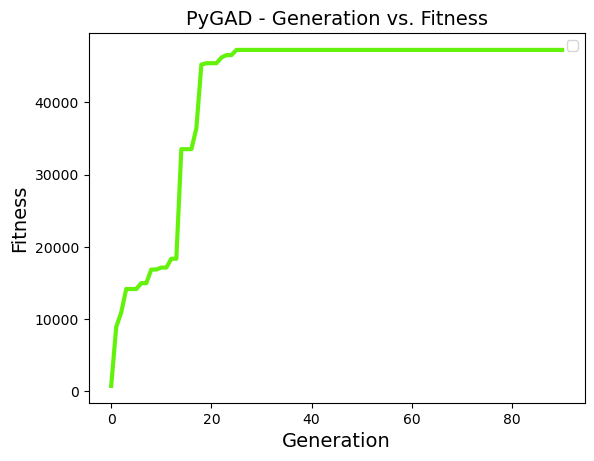

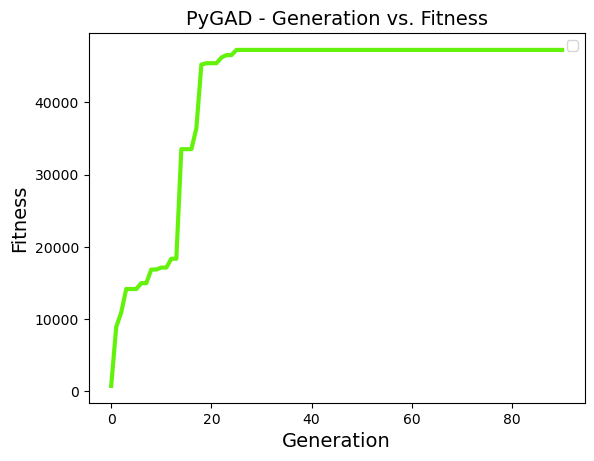

In [17]:
ga_instance.plot_fitness()


In [18]:
# Show details of the best solution.
solution, solution_fitness, _ = ga_instance.best_solution()

print(f' Best Solution Parameters '.center(60, '*'))
print(f"Min Bandwidth    : {solution[0]:6.4f}")
print(f"Max Perc to Buy  : {solution[1]:6.2f}")
print(f"Min Perc to Sell : {solution[2]:6.2f}")

# Get Reward from train data
profit, wins, losses, result = get_result(train, solution[0], solution[1], solution[2])

print(f' Result (TRAIN) '.center(60, '*'))
print(f"* Profit / Loss  : {profit:.2f}")
print(f"* Wins / Losses  : {wins} / {losses}")
print(f"* Win Rate       : {(100 * (wins/(wins + losses)) if wins + losses > 0 else 0):.2f}%")

# Get Reward from test data
profit, wins, losses, result2 = get_result(test, solution[0], solution[1], solution[2])

# Show the final result
print(f' Result (TEST) '.center(60, '*'))
print(f"* Profit / Loss  : {profit:.2f}")
print(f"* Wins / Losses  : {wins} / {losses}")
print(f"* Win Rate       : {(100 * (wins/(wins + losses)) if wins + losses > 0 else 0):.2f}%")

***************** Best Solution Parameters *****************
Min Bandwidth    : 0.0016
Max Perc to Buy  :   0.35
Min Perc to Sell :   0.63
********************** Result (TRAIN) **********************
* Profit / Loss  : 47270.80
* Wins / Losses  : 2471 / 1302
* Win Rate       : 65.49%
********************** Result (TEST) ***********************
* Profit / Loss  : 6066.21
* Wins / Losses  : 868 / 472
* Win Rate       : 64.78%


In [19]:
result2

,date,close,BBL_10_2.0,BBM_10_2.0,BBU_10_2.0,BBB_10_2.0,BBP_10_2.0,high_limit,low_limit,close_percentage,bandwidth,signal,total_reward
36,2022-12-21 14:20:00,386.829987,386.782317,387.090497,387.398677,0.159229,0.077341,387.706857,386.474136,0.288671,0.001592,1,0.000000
49,2022-12-21 14:33:00,386.755005,386.298981,386.588504,386.878027,0.149784,0.787543,387.167550,386.009458,0.643772,0.001498,-1,-20.383629
52,2022-12-21 14:36:00,386.320007,386.210411,386.533002,386.855592,0.166915,0.169869,387.178182,385.887821,0.334934,0.001669,1,0.000000
62,2022-12-21 14:46:00,386.579987,386.254716,386.431497,386.608278,0.091494,0.919981,386.785059,386.077935,0.709991,0.000915,-1,66.296346
68,2022-12-21 14:52:00,385.870911,385.917860,386.299258,386.680657,0.197463,-0.061549,387.062056,385.536461,0.219226,0.001975,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68767,2023-09-08 12:40:00,446.154999,445.913371,446.045013,446.176656,0.059026,0.917743,446.308298,445.781729,0.708872,0.000590,-1,-6.601752
68776,2023-09-08 12:49:00,445.790009,445.707020,446.074841,446.442662,0.164915,0.112811,446.810484,445.339199,0.306405,0.001649,1,0.000000
68783,2023-09-08 12:56:00,445.959991,445.683128,445.835208,445.987289,0.068223,0.910254,446.139369,445.531047,0.705127,0.000682,-1,37.130713
68858,2023-09-08 14:11:00,445.209991,445.446786,446.014966,446.583145,0.254781,-0.208380,447.151325,444.878607,0.145810,0.002548,1,0.000000
